In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from datetime import datetime, timedelta
import gc

from fastai import *
from fastai.vision import *
from fastai.tabular import *
from scripts import m5_common
from tqdm.notebook import tqdm

In [3]:
pd.options.display.max_columns = 50

## Setup variables

In [4]:
path = Path('/kaggle/m5_forecasting/')
assert(path.exists())

In [5]:
FIRST_DAY = 1

In [6]:
h = 28 
max_lags = h * 2 + 1
tr_last = 1913
fday = datetime(2016, 4, 25)

## Read Data

In [7]:
%%time

prices, cal = m5_common.prepare_tables(path)

CPU times: user 1.44 s, sys: 144 ms, total: 1.59 s
Wall time: 1.58 s


In [8]:
event_name_1_map, event_type_1_map = m5_common.replace_cal_cols(cal)

In [9]:
cal[(cal.date > '2012-01-01') & (cal.date < '2012-01-05')]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
338,2012-01-02,11149,1,3,1,2012,d_339,0,0,0,0,1.0,0.0,1.0
339,2012-01-03,11149,5,4,1,2012,d_340,0,0,0,0,1.0,1.0,1.0
340,2012-01-04,11149,6,5,1,2012,d_341,0,0,0,0,1.0,0.0,0.0


In [10]:
uint8_types= ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'month', 'wday', 'weekday', 
              'snap_CA', 'snap_TX', 'snap_WI']
m5_common.convert_uint8(cal, uint8_types)

In [11]:
m5_common.add_days_before(cal)

In [12]:
%%time

df = m5_common.create_dt(cal, prices, is_train=True, first_day=FIRST_DAY, tr_last=tr_last, path=path)

CPU times: user 41.9 s, sys: 5.85 s, total: 47.8 s
Wall time: 47.8 s


In [13]:
df.date.min(), df.date.max()

(Timestamp('2011-01-29 00:00:00'), Timestamp('2016-04-24 00:00:00'))

## Create features

In [14]:
def create_fea(dt):
    
    wins = [7, 28]
    lags = [7, 28]
    
    grouped_sales = dt[["id","sales"]].groupby("id")["sales"]
    
    for win in tqdm(wins, total=len(wins)):
        mean_col = f'mean_{win}'
        emean_col = f'e{mean_col}' # exponential mean average
        esmean_col = f'es{mean_col}'
        dt[emean_col] = grouped_sales.transform(lambda x : x.ewm(span=win, adjust=False).mean())
        dt[esmean_col] = grouped_sales.transform(lambda x : x.ewm(alpha=1/win, adjust=False).mean())
        for lag in lags:
            dt[f'emean_{win}_{lag}'] = dt[["id", emean_col]].groupby("id").shift(lag)
            dt[f'esmean_{win}_{lag}'] = dt[["id", esmean_col]].groupby("id").shift(lag)
        del dt[emean_col]
        del dt[esmean_col]
            
    ra = [1, 2]
    for simple_lag in ra:
        dt[f'lag_{simple_lag}'] = dt[["id","sales"]].groupby("id")["sales"].shift(simple_lag)

In [15]:
%%time

create_fea(df)


CPU times: user 1min 27s, sys: 6.64 s, total: 1min 34s
Wall time: 1min 34s


In [16]:
df.dropna(inplace = True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45174237 entries, 342559 to 46025082
Data columns (total 37 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              int16         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap_CA           uint8         
 19  snap_TX           uint8         
 20  snap_WI           uint8         
 21  b

## Training Preparation

In [18]:
cat_feats = ['wday', 'month', 'year', 'Dayofyear', 'before_christmas', 'week', 'mday','item_id', 'dept_id','store_id', 'cat_id', 'state_id', 
             "event_name_1", "event_name_2", "event_type_1",  "event_type_2", 'snap_CA', 'snap_TX', 'snap_WI']
useless_cols = ["id", "date", "sales", "sales_positive", "d", "wm_yr_wk", "weekday", "revenue"]

train_cols = df.columns[~df.columns.isin(useless_cols)]
cont_names = [col for col in train_cols if col not in cat_feats]

In [19]:
procs = [FillMissing, Categorify, Normalize]

In [20]:
def convert_float32(df):
    for c in ['sell_price', 'lag_price_1', 'emean_7_7', 'esmean_7_7', 'emean_7_28', 'esmean_7_28', 'emean_28_7', 'esmean_28_7', 'emean_28_28', 'esmean_28_28', 'lag_1', 'lag_2']:
        df[c] = df[c].astype('float32')
        
convert_float32(df)

In [21]:
data = (TabularList.from_df(df, path=path, cat_names=cat_feats, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(valid_pct=0.1)
                           .label_from_df(cols='sales', label_cls=FloatList)
                           .databunch())
data.batch_size=2048

In [22]:
data.show_batch(rows=10)

wday,month,year,Dayofyear,before_christmas,week,mday,item_id,dept_id,store_id,cat_id,state_id,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_price_1,emean_7_7,esmean_7_7,emean_7_28,esmean_7_28,emean_28_7,esmean_28_7,emean_28_28,esmean_28_28,lag_1,lag_2,target
7,7,2014,199,160,29,18,1702,4,9,2,2,0,0,0,0,0,0,0,1.0122,1.0123,-0.1140,-0.1013,-0.0774,-0.0512,-0.0493,-0.0038,-0.0053,0.0330,-0.3056,-0.3055,1.0
1,10,2013,299,60,43,26,989,2,8,1,2,0,0,0,0,0,0,0,0.1060,0.1060,-0.2171,-0.1559,-0.0737,-0.0775,-0.1077,-0.0814,-0.0493,-0.0436,0.1787,-0.3055,2.0
4,7,2015,195,164,29,14,2417,6,2,2,0,0,0,0,0,0,0,1,-0.3386,-0.3386,-0.2740,-0.2606,-0.2089,-0.2048,-0.2444,-0.2303,-0.2021,-0.2018,-0.3056,-0.3055,0.0
1,11,2015,332,27,48,28,788,2,4,1,1,0,0,0,0,0,0,0,1.7679,1.7680,-0.2282,-0.2419,-0.2777,-0.2718,-0.2564,-0.2677,-0.2840,-0.2854,-0.3056,-0.3055,0.0
6,12,2012,355,5,51,20,1655,4,7,2,2,0,0,0,0,0,0,0,0.7017,0.7017,-0.3313,-0.3359,-0.3301,-0.3344,-0.3413,-0.3459,-0.3393,-0.3432,-0.3056,-0.3055,0.0
6,9,2014,268,91,39,25,463,1,2,0,0,0,0,0,0,0,0,0,-0.2234,-0.2234,-0.1426,-0.1825,-0.1523,-0.1762,-0.2020,-0.2048,-0.1882,-0.1921,-0.3056,-0.3055,0.0
7,12,2011,336,23,48,2,9,0,2,0,0,0,0,0,0,1,0,1,-0.1963,-0.1963,-0.2409,-0.2340,-0.2161,-0.1506,-0.1883,-0.1387,-0.0960,-0.0688,-0.0635,0.4206,1.0
6,4,2014,100,259,15,10,1135,3,4,1,1,0,0,0,0,1,0,0,1.7089,1.7089,-0.3271,-0.3168,-0.1477,-0.1480,-0.2884,-0.2737,-0.1758,-0.2178,-0.3056,-0.3055,0.0
1,7,2011,211,148,30,30,2466,6,6,2,1,0,0,0,0,0,0,0,1.8931,1.8931,-0.1875,-0.1814,-0.1846,-0.1646,-0.1762,-0.1789,-0.1632,-0.1768,-0.3056,-0.3055,1.0
2,6,2011,177,182,25,26,2925,6,2,2,0,0,0,0,0,0,0,0,-0.1933,-0.1933,7.2857,7.3117,4.3610,3.4964,6.2731,4.7519,2.4534,1.8260,12.5283,13.0068,45.0


In [23]:
data.x.cont_names

['sell_price',
 'lag_price_1',
 'emean_7_7',
 'esmean_7_7',
 'emean_7_28',
 'esmean_7_28',
 'emean_28_7',
 'esmean_28_7',
 'emean_28_28',
 'esmean_28_28',
 'lag_1',
 'lag_2']

In [24]:
max_y = np.max(df['sales'] * 1.2)
y_range = torch.tensor([0., max_y], device=defaults.device)

In [25]:
del df
gc.collect()

70

## Training

In [26]:
# inline static double LossOnPoint(label_t label, double score, const Config& config) {
#     const double rho = config.tweedie_variance_power;
#     const double eps = 1e-10f;
#     if (score < eps) {
#       score = eps;
#     }
#     const double a = label * std::exp((1 - rho) * std::log(score)) / (1 - rho);
#     const double b = std::exp((2 - rho) * std::log(score)) / (2 - rho);
#     return -a + b;
#   }

In [27]:
def mse_loss(pred, targ):
    pred, targ = pred.contiguous().view(-1),targ.contiguous().view(-1)
    return F.mse_loss(pred, targ)

In [28]:
tweedie_variance_power = 1.1
rho = tensor(tweedie_variance_power).cuda()
eps = tensor(1e-10).cuda()

def tweedie_loss(pred, targ):
    pred, targ = pred.contiguous().view(-1), targ.contiguous().view(-1)
    pred = torch.where(pred < eps, eps, pred)
    a = targ * torch.exp((1 - rho) * torch.log(pred)) / (1 - rho)
    b = torch.exp((2 - rho) * torch.log(pred)) / (2 - rho)
    return torch.mean(-a + b)

def mse_tweedie_loss(pred, targ):
    return (mse_loss(pred, targ) * 0.7 + tweedie_loss(pred, targ) * 0.3) / tensor(2.).cuda()

In [29]:


def mqe_loss(pred, targ):
    pred, targ = pred.contiguous().view(-1),targ.contiguous().view(-1)
    return torch.mean((pred - targ) ** 4)

def mae_loss(pred, targ):
    pred, targ = pred.contiguous().view(-1),targ.contiguous().view(-1)
    return torch.mean(torch.abs(pred - targ))

def mape_loss(pred, targ):
    pred, targ = pred.contiguous().view(-1),targ.contiguous().view(-1)
    return torch.mean(torch.abs((targ - pred) / (targ + 1e-5)))

def poisson_loss(pred, targ):
    """Custom loss function for Poisson model."""
    pred, targ = flatten_check(pred, targ)
    return F.poisson_nll_loss(pred, targ)

In [30]:
class ExportModelCallback(callbacks.TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'

    def jump_to_epoch(self, epoch:int)->None:
        try:
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                learn.export(file=str(path/f'm5_model_{self.name}_{epoch}_export.pkl'))

    def on_train_end(self, **kwargs):
        "Load the best model."
        if self.every=="improvement" and (self.learn.path/f'{self.learn.model_dir}/{self.name}.pth').is_file():
            self.learn.load(f'{self.name}', purge=False)

In [31]:
learn = tabular_learner(data, layers=[2000, 1000], y_range=y_range, metrics=rmse)

In [32]:
learn.loss_func = tweedie_loss

In [33]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(8, 5)
    (1): Embedding(13, 7)
    (2): Embedding(7, 5)
    (3): Embedding(367, 44)
    (4): Embedding(367, 44)
    (5): Embedding(54, 15)
    (6): Embedding(32, 11)
    (7): Embedding(3050, 143)
    (8): Embedding(8, 5)
    (9): Embedding(11, 6)
    (10): Embedding(4, 3)
    (11): Embedding(4, 3)
    (12): Embedding(32, 11)
    (13): Embedding(6, 4)
    (14): Embedding(6, 4)
    (15): Embedding(4, 3)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=334, out_features=1500, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1500, out_features=750, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(

In [34]:
learn.lr_find(num_it=400)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


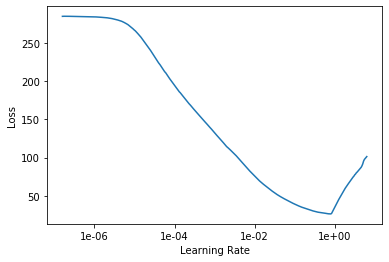

In [35]:
learn.recorder.plot()

In [36]:
lr = 1e-3

In [37]:
%%time
learn.fit_one_cycle(10, lr, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="root_mean_squared_error", 
                                                                       mode="min", patience=30),
                                     ExportModelCallback(learn, monitor='root_mean_squared_error',mode='min', 
                                                                 name='m5_best_1')])

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,13.437209,13.529675,2.415637,05:26
1,13.348128,13.539217,2.762244,05:34
2,13.384420,13.492005,2.203611,05:37
3,13.643293,13.509173,3.492695,05:41
4,13.508963,13.506639,2.529145,05:43
5,13.593192,13.488234,2.309223,05:46
6,13.378476,13.506940,2.223980,05:48
7,13.530737,13.501881,2.192713,05:50
8,13.362758,13.513652,2.141825,05:52
9,13.332985,13.519606,2.138734,05:56


Better model found at epoch 0 with root_mean_squared_error value: 2.4156365394592285.
Better model found at epoch 2 with root_mean_squared_error value: 2.20361065864563.
Better model found at epoch 7 with root_mean_squared_error value: 2.192713499069214.
Better model found at epoch 8 with root_mean_squared_error value: 2.141824960708618.
Better model found at epoch 9 with root_mean_squared_error value: 2.1387336254119873.
CPU times: user 55min 11s, sys: 2min, total: 57min 12s
Wall time: 57min 18s


In [38]:
%%time

lr = 1e-5
learn.fit_one_cycle(10, lr, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="root_mean_squared_error", 
                                                                       mode="min", patience=30),
                                     ExportModelCallback(learn, monitor='root_mean_squared_error',mode='min', 
                                                                 name='m5_best_2')])

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,13.469638,13.485523,2.204345,05:30
1,13.625857,13.490778,2.224739,05:33
2,13.404648,13.489248,2.217340,05:36
3,13.567204,13.502091,2.183409,05:40
4,13.493550,13.485554,2.212190,05:43
5,13.452810,13.505648,2.283897,05:46
6,13.501394,13.520200,2.202652,05:47
7,13.486872,13.487467,2.198567,05:49
8,13.384757,13.487103,2.238982,05:51
9,13.513433,13.492805,2.248522,05:55


Better model found at epoch 0 with root_mean_squared_error value: 2.204345464706421.
Better model found at epoch 3 with root_mean_squared_error value: 2.183408737182617.
CPU times: user 55min 13s, sys: 2min 1s, total: 57min 15s
Wall time: 57min 17s


In [39]:
!ls {path}

calendar.csv	       m5_model_2_export.pkl  m5_model.pth
m5_best_1.pth	       m5_model_2.lgb	      m5_models.tgz
m5_best_2.pth	       m5_model_3_export.pkl  m5_model_tweedie_1.2_800.lgb
m5_dt		       m5_model_3.lgb	      models
m5_model	       m5_model_4.lgb	      sales_train_validation.csv
m5_model_0_export.pkl  m5_model_7_export.pkl  sample_submission.csv
m5_model_0.lgb	       m5_model_800.lgb       sell_prices.csv
m5_model_1000.lgb      m5_model_8_export.pkl  temperature_us.zip
m5_model_1200.lgb      m5_model_9_export.pkl  unemployment_us.csv
m5_model_1400.lgb      m5_model_best.lgb      walmartTrends0.csv
m5_model_1500.lgb      m5_model_binary.lgb    weather
m5_model_1.lgb	       m5_model.lgb


In [40]:
learn.export(file=str(path/'m5_model'))

In [41]:
learn = load_learner(path=str(path), file='m5_model')

## Prediction

In [83]:
from tqdm.notebook import tqdm

In [84]:
def fastai_tabular_predict(tst):
    '''
    tst - a dataframe missing the label for which we want to be able to predict
    '''
    # sales is the label
    tst['sales'] = 0
    # Create a databunch with the same categorical features, continuous features and procedures as for the training set, split so that you only have training data
    tbldb = TabularList.from_df(
        tst, path=path, cat_names=cat_feats, cont_names=cont_names, procs=procs).split_by_rand_pct(valid_pct=0.).label_from_df(
        cols='sales', label_cls=FloatList).add_test(TabularList.from_df(tst, path=path, cat_names=cat_feats, cont_names=cont_names)).databunch()
    # Set the batch size to the length of the dataframe
    tbldb.batch_size = len(tst)
    # Fetch the training data features
    x, _ = next(iter(tbldb.dl(ds_type=DatasetType.Test)))
    # Call the model using first the categorical data and then the continuous data, convert to numpy
    return to_np(learn.model(x[0].cuda(), x[1].cuda()).squeeze())

In [85]:
%%time

max_lags = h * 2 + 1
sub = 0.
cols = [f"F{i}" for i in range(1,29)]
te = m5_common.create_dt(cal, prices, False, first_day=FIRST_DAY, path=path)

learn.model.eval()

for tdelta in tqdm(range(0, h), total=h):
    day = fday + timedelta(days=tdelta)
    print(tdelta, day)
    tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
    create_fea(tst)
    tst = tst.loc[tst.date == day, train_cols]
    convert_float32(tst)
    te.loc[te.date == day, "sales"] = fastai_tabular_predict(tst)
    break

0 2016-04-25 00:00:00



CPU times: user 1min 27s, sys: 7.79 s, total: 1min 35s
Wall time: 1min 36s


In [89]:
Counter(te.loc[te.date == day]['sales'] > 1), Counter(te.loc[te.date == day]['sales'] > 0.5), Counter(te.loc[te.date == day]['sales'] > 0.25), Counter(te.loc[te.date == day]['sales'] > 0.1) 

(Counter({False: 29483, True: 1007}),
 Counter({False: 28092, True: 2398}),
 Counter({False: 25538, True: 4952}),
 Counter({False: 20940, True: 9550}))

In [77]:
%%time

te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
                                                                      "id"].str.replace("validation$", "evaluation")
te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
te_sub.fillna(0., inplace = True)
te_sub.sort_values("id", inplace = True)
te_sub.reset_index(drop=True, inplace = True)
sub = te_sub

CPU times: user 2.98 s, sys: 249 ms, total: 3.23 s
Wall time: 3.23 s


In [78]:
%time

sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [ ]:
!wc -l submission.csv

In [49]:
pd.read_csv('submission.csv')

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,9.480000e-02,0.000136,0.101200,9.026000e-03,0.000983,0.000500,2.400000e-07,0.17650,1.282000e-01,1.089500e-01,2.064000e-03,0.291000,0.000025,0.104740,0.000025,0.000994,0.138100,0.173100,3.860000e-02,3.716000e-03,0.66650,0.607000,0.056240,0.004356,3.270000e-02,0.000849,0.014305,0.002730
1,FOODS_1_001_CA_2_validation,3.000000e-07,0.033300,0.000124,3.525000e-01,0.383500,0.109000,9.235000e-02,0.03840,1.768000e-01,1.627000e-02,1.481000e-01,0.220700,3.291000,0.362800,0.395000,0.016310,0.272200,0.000243,1.059600e-01,5.520000e-02,0.05603,0.011240,0.168500,0.070070,4.110000e-05,1.354000,0.093600,0.000004
2,FOODS_1_001_CA_3_validation,9.660000e-02,0.000185,0.000010,3.490000e-01,0.000003,0.015274,7.690000e-05,0.02711,5.685000e-02,2.422000e-01,4.858000e-01,0.156200,0.000010,0.000000,0.040530,0.000025,0.025910,0.003967,2.411000e-02,7.880000e-03,0.04968,0.000197,0.201500,0.015060,2.283000e-01,0.125900,0.000011,0.198400
3,FOODS_1_001_CA_4_validation,1.000000e-07,0.915000,0.657700,6.216000e-01,0.189200,0.368700,2.210000e-02,0.06320,1.141000e-01,1.872000e-02,3.912000e-02,0.214100,0.031100,0.128700,0.004990,0.000409,0.006897,0.000167,1.135000e-01,1.458000e-01,0.22060,0.137600,0.060940,0.000601,5.000000e-07,0.079200,1.194000,0.138800
4,FOODS_1_001_TX_1_validation,3.127000e-01,1.156000,0.012060,1.543000e-04,0.079350,0.033260,3.809000e-01,0.02704,1.523600e-02,1.000000e-07,6.000000e-08,0.006960,0.002821,0.022720,0.113000,0.017800,0.000485,0.639600,6.000000e-08,3.192000e-02,0.01483,0.238200,0.165800,0.031280,6.396000e-02,0.016300,0.079040,0.295700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_TX_2_evaluation,6.510000e-02,0.139800,0.671000,1.848000e-01,0.188100,0.579000,1.787000e-04,0.31700,1.812500e+00,9.600000e-02,5.430000e-02,0.000036,0.258500,0.151500,0.240500,0.033870,0.014050,0.015730,8.935000e-05,4.070000e-01,0.47680,0.156200,0.000803,0.033500,1.128000e-01,0.352500,0.015950,0.032700
60976,HOUSEHOLD_2_516_TX_3_evaluation,0.000000e+00,0.053650,0.297000,6.757000e-02,0.081300,0.016310,7.863000e-04,0.07150,2.300000e-06,1.842000e-04,1.962000e-02,0.014680,0.000031,0.000017,0.000040,0.000886,0.371000,0.000857,2.551000e-01,3.525000e-01,0.01410,0.013306,0.000221,0.000046,1.825000e-01,0.000841,0.002708,0.318000
60977,HOUSEHOLD_2_516_WI_1_evaluation,1.504000e-01,0.113300,0.003443,5.000000e-07,0.331800,0.053400,2.400000e-07,1.71600,2.000000e-07,7.167000e-04,4.890000e-03,0.378700,1.762000,0.023160,0.000003,0.092900,0.000860,0.000034,4.462000e-02,5.190000e-03,0.00354,0.005420,0.004290,0.000030,1.613000e-01,0.012580,0.000052,0.359100
60978,HOUSEHOLD_2_516_WI_2_evaluation,2.200000e-01,0.002375,0.081000,3.660000e-01,0.382600,0.706500,1.689000e-04,0.00860,5.765000e-04,1.990000e-04,7.240000e-01,0.459200,0.000005,0.085600,0.001839,0.908000,0.000031,0.219400,5.650000e-02,2.087000e-02,0.03552,0.076350,0.921400,0.000005,2.179000e-01,0.511000,0.665000,0.036930
